In [ ]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

!wget -qO- https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz | tar xz

In [48]:
import pickle
from image_utils import make_image
import numpy as np
from PIL import Image, ImageEnhance, ImageDraw

In [ ]:
def unpickle(file):
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

def reshape_cifar_pixels(pxs):
  return list(zip(pxs[:1024], pxs[1024:2048], pxs[2048:]))

In [ ]:
res = unpickle("./cifar-10-batches-py/data_batch_1")

In [ ]:
for i in range(10):
  display(make_image(reshape_cifar_pixels(res[b'data'][i])))

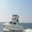

In [ ]:


# Step 1: Extract all images from the dataset
all_images = res[b'data']  # Shape: (10000, 3072)

# Step 2: Reshape into (10000, 32, 32, 3) for R, G, B
# CIFAR-10 stores 1024 R, 1024 G, 1024 B values per image
reshaped_images = all_images.reshape(-1, 3, 1024).transpose(0, 2, 1).reshape(-1, 32, 32, 3)


image_rgb = reshaped_images[100] #put in the index of image desired
img = Image.fromarray(image_rgb.astype('uint8'))  # Convert to an image
img.show()

In [19]:

pixel_values = image_rgb.reshape(-1, 3).tolist() #just make it into list

print("First 10 pixels (R, G, B):", pixel_values[:10]) #printing pixel values (first 10 pixels)
print("Total number of pixels:", len(pixel_values)) 

First 10 pixels (R, G, B): [[59, 62, 63], [43, 46, 45], [50, 48, 43], [68, 54, 42], [98, 73, 52], [119, 91, 63], [139, 107, 75], [145, 110, 80], [149, 117, 89], [149, 120, 93]]
Total number of pixels: 1024


Resize the image to a larger image for visualization (original size is 32 x 32)(pixelated)

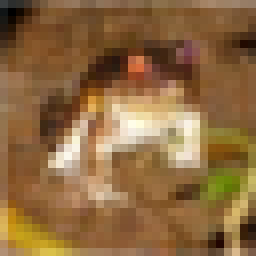

In [17]:
image_rgb = reshaped_images[0]


img = Image.fromarray(image_rgb.astype('uint8'))

# Step 3: Resize the image (e.g., scale to 256x256 for better visibility)
larger_img = img.resize((256, 256), Image.NEAREST)  # Use NEAREST to keep pixel style

# Step 4: Display the resized image
larger_img.show()

Saturated the Image below

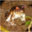

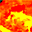

In [30]:
image_rgb = reshaped_images[0]
img = Image.fromarray(image_rgb.astype('uint8'))  
img.show()



image_rgb = reshaped_images[0]
pixels = np.array(image_rgb, dtype=np.float32)  # using float becasue it was overflow before
sat_pixels = []


saturation_factor = 22.0 #22--> 2200%
for r, g, b in pixels.reshape(-1, 3): 
    avg = (r + g + b) / 3 #i beleive avg is grayscale??
    
    new_r = avg + (r - avg) * saturation_factor
    new_g = avg + (g - avg) * saturation_factor
    new_b = avg + (b - avg) * saturation_factor
    

    sat_pixels.append((min(255, max(0, new_r)), 
                       min(255, max(0, new_g)), 
                       min(255, max(0, new_b))))
    # making sure in the valid range (0–255)

sat_pixels = np.array(sat_pixels).reshape(32, 32, 3).astype('uint8') 
# i need to reshape it back and converit it to the Unit 8 thing, i serached online and it says i have to do this. 


#saturated_img = Image.fromarray(sat_pixels) # convert back to PIL, but #this code out the img still works, bet it wrote the memory
saturated_img.show()


Im trying to train the model --> there are two models, 1 encoder, 2 decoder, for:

Analyzes an image's red pixel intensity:
For each input image (e.g., from the CIFAR-10 dataset), the system calculates how "red" the image is by examining its red pixel values.
Uses the red pixel intensity to reconstruct a heart shape:
The red pixel intensity determines the size or intensity of the reconstructed heart shape.
Very red image --> Larger or more vibrant heart.
Less red image --> Smaller or fainter heart.

This involves:

Encoder: Encodes an input image by extracting relevant features (e.g., the red pixel intensity).
Decoder: Takes the encoded features (e.g., red intensity) and outputs a new image—a heart shape reconstructed based on the red pixel data.

In [58]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [ ]:
# Function to calculate red intensity
def calculate_red_intensity(image):
    # Ensure the input is a 3D tensor (C, H, W)
    if len(image.shape) != 3:
        raise ValueError(f"Expected 3D tensor (C, H, W), but got {image.shape}") #unfamiliar with raise, practicing

    red_channel = image[0, :, :]
    
    # Calculate total and normalized red intensity
    total_red = red_channel.sum().item()
    max_red = red_channel.numel() * 255
    red_intensity = total_red / max_red
    return red_intensity



def create_heart_image(intensity, size=(32, 32)):
    heart_size = int(intensity * size[0] / 2)
    heart_img = Image.new("RGB", size, "black")
    draw = ImageDraw.Draw(heart_img)
    draw.polygon([
        (size[0] // 2, size[1] // 8),
        (size[0] // 8, 7 * size[1] // 8),
        (size[0] // 2, size[1] - size[1] // 8),
        (7 * size[0] // 8, 7 * size[1] // 8),
    ], fill=(int(255 * intensity), 0, 0))
    return ToTensor()(heart_img)

#drawinf heart shaped based on the intensity of the red colorsm



In [60]:

# Convert images to tensors and make sure size consistency
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)) 
])


cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)



# Custom Dataset for Spy Image (base and secret pairs)
class SpyImageDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        base_image, _ = self.dataset[idx]
        secret_image, _ = self.dataset[(idx + 1) % len(self.dataset)]  # Use the next image as the secret
        return base_image, secret_image

# Create train and test datasets
spy_dataset = SpyImageDataset(cifar10)
train_loader = DataLoader(spy_dataset, batch_size=32, shuffle=True)



Files already downloaded and verified


In [53]:
import torch.nn as nn

# Encoder: Embed secret image into the base image
class SpyEncoder(nn.Module):
    def __init__(self):
        super(SpyEncoder, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, base, secret):
        x = torch.cat([base, secret], dim=1)  # Concatenate along channel axis
        x = torch.relu(self.conv1(x))
        encoded = torch.sigmoid(self.conv2(x))  # Output encoded image
        return encoded

# Decoder: Extract secret image from the encoded image
class SpyDecoder(nn.Module):
    def __init__(self):
        super(SpyDecoder, self).__init__()

    def forward(self, encoded_images):
        # Ensure the input is a 4D tensor (B, C, H, W)
        if len(encoded_images.shape) != 4:
            raise ValueError(f"Expected 4D tensor (B, C, H, W), but got {encoded_images.shape}")

        # Process each image in the batch
        heart_images = []
        for image in encoded_images:  # Loop through batch
            red_intensity = calculate_red_intensity(image)  # Calculate red intensity
            heart_image = create_heart_image(red_intensity)  # Create heart image
            heart_images.append(heart_image)
        
        # Stack the heart images to match batch format
        return torch.stack(heart_images)

# Initialize models
encoder = SpyEncoder()
decoder = SpyDecoder()


In [54]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
loss_fn = nn.MSELoss()


In [55]:
epochs = 2  # Adjust as needed
for epoch in range(epochs):
    for base_image, secret_image in train_loader:
        optimizer.zero_grad()
        
        # Forward pass: encode and decode
        encoded_image = encoder(base_image, secret_image)
        decoded_secret = decoder(encoded_image)
        
        # Compute loss
        loss = loss_fn(decoded_secret, secret_image)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Print loss every epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

NameError: name 'ToTensor' is not defined

In [ ]:
# Test with a single CIFAR-10 image
base_image, _ = spy_dataset[0]  # Use first CIFAR-10 image
base_image = base_image.unsqueeze(0)  # Add batch dimension

# Use the trained encoder to encode the image (optional if pre-encoded)
with torch.no_grad():
    encoded_image = encoder(base_image, base_image)  # Use the same image as base and secret for testing

# Use the updated decoder to generate the heart image
decoder = SpyDecoder()
with torch.no_grad():
    heart_image = decoder(encoded_image[0])  # Pass encoded image to decoder

# Visualize the results


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(base_image.squeeze().permute(1, 2, 0).numpy())
plt.title("Base Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(heart_image.permute(1, 2, 0).numpy())
plt.title("Heart Image")
plt.axis("off")
plt.show()


ValueError: Expected 4D tensor (B, C, H, W), but got torch.Size([3, 32, 32])

trying new thing - determine the dominant color

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Step 1: Define transforms to normalize and resize the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# Step 2: Download and load CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Step 3: Split dataset into train and validation sets (if needed)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Step 4: Create DataLoader objects for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 5: Extract tensors for x_train, y_train, x_test, and y_test
# Extract tensors from train dataset
x_train = torch.cat([data[0].unsqueeze(0) for data in train_dataset], dim=0)
y_train = torch.tensor([data[1] for data in train_dataset])

# Extract tensors from test dataset
x_test = torch.cat([data[0].unsqueeze(0) for data in test_dataset], dim=0)
y_test = torch.tensor([data[1] for data in test_dataset])

# Step 6: Verify shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


Files already downloaded and verified
Files already downloaded and verified
x_train shape: torch.Size([40000, 3, 32, 32]), y_train shape: torch.Size([40000])
x_test shape: torch.Size([10000, 3, 32, 32]), y_test shape: torch.Size([10000])


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from data_utils import classification_error, display_confusion_matrix

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

# CIFAR-10 Dataset
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to compute dominant color
def get_dominant_color(image):
    avg_color = image.mean(dim=(1, 2))  # Mean across width and height
    return avg_color.argmax().item()  # Index of the channel with max mean value (R, G, or B)

# Custom Dataset for Dominant Color Classification
class DominantColorDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        label = get_dominant_color(image)
        return image, label

# DataLoader
dominant_dataset = DominantColorDataset(cifar10)
train_loader = DataLoader(dominant_dataset, batch_size=32, shuffle=True)

# Simple CNN Model
class ColorPredictor(nn.Module):
    def __init__(self):
        super(ColorPredictor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 3)  # Output for R, G, B

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Training
model = ColorPredictor()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 2 #ive tried 5 and the value bounced back, for some reason 2 and 4 are the lowest
for epoch in range(epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


Files already downloaded and verified
Epoch [1/2], Loss: 0.2478
Epoch [2/2], Loss: 0.0981


Train Classification Error: 0.0900
Test Classification Error: 0.9420
Train Confusion Matrix:
Test Confusion Matrix:


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (3).

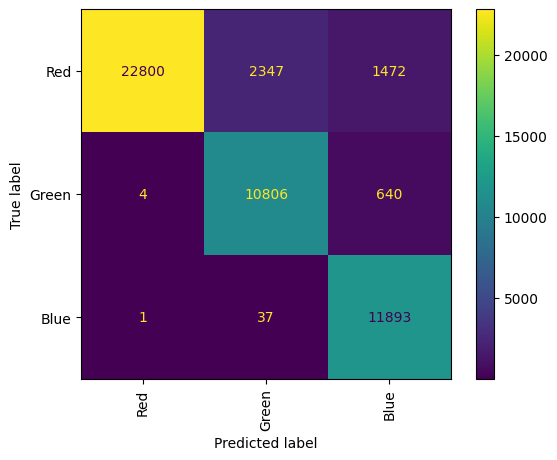

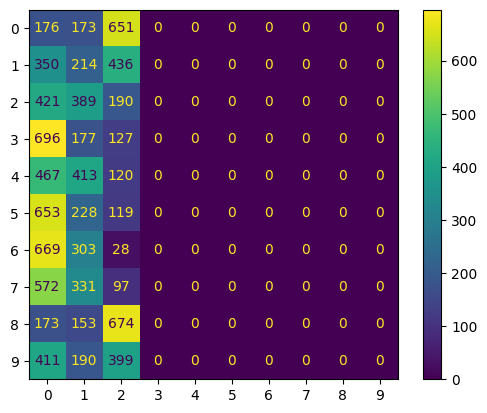

In [12]:
from data_utils import classification_error, display_confusion_matrix

# Function to get true labels and predictions from the model
def get_labels_and_predictions(model, dataloader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)  # Get model predictions
            predictions = outputs.argmax(dim=1)  # Get the class with max probability
            true_labels.extend(labels.numpy())  # Collect true labels
            predicted_labels.extend(predictions.numpy())  # Collect predicted labels
    return true_labels, predicted_labels

# Get true and predicted labels for train and test datasets
train_labels, train_predictions = get_labels_and_predictions(model, train_loader)
test_labels, test_predictions = get_labels_and_predictions(model, test_loader)

# Calculate classification error
train_error = classification_error(train_labels, train_predictions)
test_error = classification_error(test_labels, test_predictions)

print(f"Train Classification Error: {train_error:.4f}")
print(f"Test Classification Error: {test_error:.4f}")

# Display confusion matrices using `display_confusion_matrix`
class_names = ["Red", "Green", "Blue"]  # Adjust based on dominant colors in your dataset

print("Train Confusion Matrix:")
display_confusion_matrix(train_labels, train_predictions, display_labels=class_names)

print("Test Confusion Matrix:")
display_confusion_matrix(test_labels, test_predictions, display_labels=class_names)


